In [56]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import os
import seaborn as sn
import pandas as pd

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.9.1
Num GPUs Available:  1


In [57]:
# Load datasets
IMAGES_DIR = 'datasets'
DATASET_DIRS = ['wood table', 'wood floor']
LABEL_MAP = list(range(len(DATASET_DIRS)))
IMAGES = []
LABELS = []
for i, DATASET_DIR in enumerate(DATASET_DIRS):
    for file in os.listdir(os.path.join(IMAGES_DIR, DATASET_DIR)):
        img = Image.open(os.path.join(IMAGES_DIR, DATASET_DIR, file))
        IMAGES.append(np.asarray(img))
        LABELS.append(LABEL_MAP[i])
        
temp = list(zip(IMAGES, LABELS))
random.shuffle(temp)
IMAGES, LABELS = zip(*temp)

In [58]:
split = int(len(IMAGES)*0.8)
train_images = np.asarray(IMAGES[:split])
train_labels = np.asarray(LABELS[:split])
test_images = np.asarray(IMAGES[split:])
test_labels = np.asarray(LABELS[split:])

train_images = train_images.astype(np.float32) / 255
test_images = test_images.astype(np.float32) / 255

print(train_labels[3])
print(train_images.shape)

1
(1600, 240, 240, 3)


1


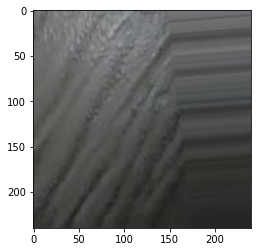

In [59]:
i = 38
print(train_labels[i])
plt.imshow(train_images[i])

In [7]:
from tensorflow.keras import layers
input_shape = (240, 240, 3)
num_classes = 2

model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=input_shape),
        layers.Conv2D(6, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(6, kernel_size=(3, 3), activation="relu"),
        layers.Flatten(),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
model.summary()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=50, batch_size=32, validation_split=0.2)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 238, 238, 6)       168       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 119, 119, 6)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 117, 117, 6)       330       
                                                                 
 flatten_2 (Flatten)         (None, 82134)             0         
                                                                 
 dense_2 (Dense)             (None, 2)                 164270    
                                                                 
Total params: 164,768
Trainable params: 164,768
Non-trainable params: 0
________________________________________________

In [8]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

13/13 [==============================] - 0s 15ms/step - loss: 0.0321 - accuracy: 0.9875
Test accuracy: 0.987500011920929


13/13 [==============================] - 0s 9ms/step


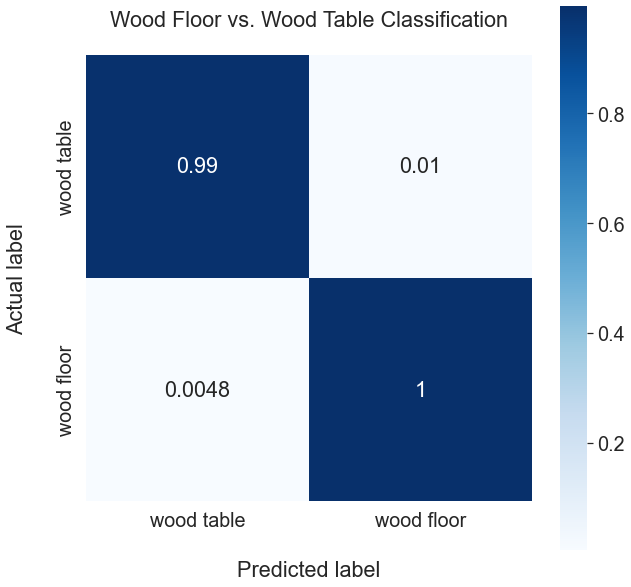

In [87]:
predictions = tf.math.argmax(model.predict(test_images), axis=1)
cf = tf.math.confusion_matrix(test_labels, predictions).numpy()
cf = cf / cf.sum(axis=1)[:, np.newaxis]
df = pd.DataFrame(cf, index=DATASET_DIRS, columns=DATASET_DIRS)
plt.figure(figsize=(10, 10))
sn.set(font_scale=1.8)
hm = sn.heatmap(df, annot=True, fmt='.2g', cmap='Blues', square=True)
plt.xlabel('Predicted label', labelpad=30)
plt.ylabel('Actual label', labelpad=30)
plt.title('Wood Floor vs. Wood Table Classification', y=1.05)
plt.savefig('confusion_matrix_2class.png')

In [9]:
model.summary()
loss, acc = model.evaluate(test_images, test_labels)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))
print("Restored model, loss: {}".format(loss))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 238, 238, 6)       168       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 119, 119, 6)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 117, 117, 6)       330       
                                                                 
 flatten_2 (Flatten)         (None, 82134)             0         
                                                                 
 dense_2 (Dense)             (None, 2)                 164270    
                                                                 
Total params: 164,768
Trainable params: 164,768
Non-trainable params: 0
________________________________________________

In [10]:
model.save('mnist-tflite')

INFO:tensorflow:Assets written to: mnist-tflite\assets


INFO:tensorflow:Assets written to: mnist-tflite\assets


In [11]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_saved_model('mnist-tflite')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
tflite_model = converter.convert()
tflite_model_size = open('./mnist_model.tflite', "wb").write(tflite_model)
print("Quantized model is %d bytes" % tflite_model_size)

Quantized model is 168656 bytes


In [ ]:
# https://www.tensorflow.org/lite/microcontrollers/build_convert
# xxd -i mnist_model.tflite > model_data.cc

# Helpful for Git Bash https://gist.github.com/evanwill/0207876c3243bbb6863e65ec5dc3f058

In [12]:
interpreter = tf.lite.Interpreter(model_path='./mnist_model.tflite')
interpreter.allocate_tensors()

print("== Input details ==")
print("name:", interpreter.get_input_details()[0]['name'])
print("shape:", interpreter.get_input_details()[0]['shape'])
print("type:", interpreter.get_input_details()[0]['dtype'])

print("\n== Output details ==")
print("name:", interpreter.get_output_details()[0]['name'])
print("shape:", interpreter.get_output_details()[0]['shape'])
print("type:", interpreter.get_output_details()[0]['dtype'])

print("\nDUMP INPUT")
print(interpreter.get_input_details()[0])
print("\nDUMP OUTPUT")
print(interpreter.get_output_details()[0])

== Input details ==
name: serving_default_input_3:0
shape: [  1 240 240   3]
type: <class 'numpy.float32'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [1 2]
type: <class 'numpy.float32'>

DUMP INPUT
{'name': 'serving_default_input_3:0', 'index': 0, 'shape': array([  1, 240, 240,   3]), 'shape_signature': array([ -1, 240, 240,   3]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}

DUMP OUTPUT
{'name': 'StatefulPartitionedCall:0', 'index': 15, 'shape': array([1, 2]), 'shape_signature': array([-1,  2]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}


In [55]:
import pathlib

tflite_models_dir = pathlib.Path(".")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

# Save the unquantized/float model:
tflite_model_file = tflite_models_dir/"mnist_model.tflite"
tflite_model_file.write_bytes(tflite_model)
# Save the quantized model:
tflite_model_quant_file = tflite_models_dir/"mnist_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

24608

In [76]:
f= open("../tensorflow-lite-esp32/firmware/src/digit.h","w")
f.write("const float digit[] = { \n")
for d in test_image.flatten():
    f.write(str(d))
    f.write(',')
f.write('\n};')
f.close()